## Double Q-Learning Tempoeral-Difference control reinforcement learning algorithm

Example of simulation of Double Q-Learning and Q-Learning. Double Q-learning maintance two Q-value functions where each one gets update from the other for the next state. The update consists of finding the action that maximises one of the Q-function in the next state, then uses the optimal action to get the value of the Q-function of the other one in order to update the Q-function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# these are the control variables, change them to customize the execution of this program
cntExperiments= 1001 # number of experiments to run, large number means longer execution time
MAX_ITER = 301      # number of episodes per experiment, large number means longer execution time
ACTIONS_FOR_B = 10  #number of actions at state B

In [3]:
#identify the states
STATE_A = 0
STATE_B = 1
STATE_C = 2
STATE_D = 3

#identify the actions
ACTION_LEFT = 0
ACTION_RIGHT = 1

In [4]:
#map actions to states
actionsPerState = {}
actionsPerState[STATE_A] = [ACTION_LEFT, ACTION_RIGHT]
actionsPerState[STATE_B] = [i for i in range(ACTIONS_FOR_B)]
actionsPerState[STATE_C] = [ACTION_RIGHT]
actionsPerState[STATE_D] = [ACTION_LEFT]

In [6]:
#init Q values
Q1={}
Q2={}

GAMMA = 1

In [7]:
# reset the variables, to be called on each experiment
def reset():
    Q1[STATE_A] = {}
    Q1[STATE_A][ACTION_LEFT] = 0
    Q1[STATE_A][ACTION_RIGHT] = 0

    Q1[STATE_B] = {}

    Q1[STATE_C] = {}
    Q1[STATE_C][ACTION_LEFT] = 0
    Q1[STATE_C][ACTION_RIGHT] = 0

    Q1[STATE_D] = {}
    Q1[STATE_D][ACTION_LEFT] = 0
    Q1[STATE_D][ACTION_RIGHT] = 0

    Q2[STATE_A] = {}
    Q2[STATE_A][ACTION_LEFT] = 0
    Q2[STATE_A][ACTION_RIGHT] = 0

    Q2[STATE_B] = {}

    Q2[STATE_C] = {}
    Q2[STATE_C][ACTION_LEFT] = 0
    Q2[STATE_C][ACTION_RIGHT] = 0

    Q2[STATE_D] = {}
    Q2[STATE_D][ACTION_LEFT] = 0
    Q2[STATE_D][ACTION_RIGHT] = 0
    for i in range(ACTIONS_FOR_B):
        Q1[STATE_B][i] = 0
        Q2[STATE_B][i] = 0

In [8]:
# epsilon greedy action
# it return action a 1-epsilon times
# and a random action epsilon times
def random_action(s, a, eps=.1):
    p = np.random.random()
    if p < (1 - eps):
        return a
    else:
        return np.random.choice(actionsPerState[s])

In [9]:
# move from state s using action a
# it returns the reward and the new state
def move(s, a):
    if(s==STATE_A):
        if(a == ACTION_LEFT): return 0, STATE_B
        else: return 0, STATE_C
    if s==STATE_B:
        return np.random.normal(-.5, 1), STATE_D
    return 0, s

In [10]:
# returns the action that makes the max Q value, as welle as the max Q value
def maxQA(q, s):
    max=-9999
    sa = 0
    for k in q[s]:
        if(q[s][k] > max):
            max = q[s][k]
            sa = k
    return sa, max

In [11]:
# return true if this is a terminal state
def isTerminal(s):
    return s == STATE_C or s == STATE_D

In [12]:
# select the initial action at state A, it uses greedy method
# it takes into the mode doubleQLearning or not
def selectInitialAction(doubleQLearning, startState):
    if doubleQLearning:
        QS = {}
        QS[STATE_A] = {}
        QS[STATE_A][ACTION_LEFT] = Q1[STATE_A][ACTION_LEFT] + Q2[STATE_A][ACTION_LEFT]
        QS[STATE_A][ACTION_RIGHT] = Q1[STATE_A][ACTION_RIGHT] + Q2[STATE_A][ACTION_RIGHT]
        a, _ = maxQA(QS, startState)

    else:
        a, _ = maxQA(Q1, startState)
    return a

In [13]:
#update Q values depending on whether the mode  is doubleQLearning or not
def updateQValues(doubleQLearning, s, a, r, nxt_s, alpha):
    if doubleQLearning:
        p = np.random.random()
        if (p < .5):
            nxt_a, maxq = maxQA(Q1, nxt_s)
            Q1[s][a] = Q1[s][a] + alpha * (r + GAMMA * Q2[nxt_s][nxt_a] - Q1[s][a])
        else:
            nxt_a, maxq = maxQA(Q2, nxt_s)
            Q2[s][a] = Q2[s][a] + alpha * (r + GAMMA * Q1[nxt_s][nxt_a] - Q2[s][a])
    else:
        nxt_a, maxq = maxQA(Q1, nxt_s)
        Q1[s][a] = Q1[s][a] + alpha * (r + GAMMA * maxq - Q1[s][a])
    return nxt_a

In [14]:
# do the experiment by running MAX_ITER episodes and fill the restults in the episods parameter
def experiment(episods, doubleQLearning = False):
    reset()
    #contains the number of times left action is chosen at A
    ALeft = 0

    # contains the number of visits for each state
    N={}
    N[STATE_A] = 1
    N[STATE_B] = 1
    N[STATE_C] = 1
    N[STATE_D] = 1

    # contains the number of visits for each state and action
    NSA = {}

    # loop for MAX_ITER episods
    for i in range(1, MAX_ITER):

        s = STATE_A
        gameover = False

        # use greedy for the action at STATE A
        a = selectInitialAction(doubleQLearning, s)

        #loop until game is over, this will be ONE episode
        while not gameover:

            # apply epsilon greedy selection (including for action chosen at STATE A)
            a = random_action(s, a, 1/np.sqrt(N[s]))

            #update the number of visits for state s
            N[s] += 1

            # if left action is chosen at state A, increment the counter
            if (s == STATE_A and a == ACTION_LEFT):
                ALeft += 1

            #move to the next state and get the reward
            r, nxt_s = move(s, a)

            #update the number of visists per state and action
            if not s in NSA:
                NSA[s] = {}
            if not a in NSA[s]:
                NSA[s][a] = 0
            NSA[s][a] += 1

            #compute alpha
            alpha = 1 / np.power(NSA[s][a], .8)

            #update the Q values and get the best action for the next state
            nxt_a = updateQValues(doubleQLearning, s, a, r, nxt_s, alpha)

            #if next state is terminal then mark as gameover (end of episode)
            gameover = isTerminal(nxt_s)

            s = nxt_s
            a = nxt_a

        #update stats for each episode
        if not (i in episods):
            episods[i] = {}
            episods[i]["count"] = 0
            episods[i]["Q1(A)"] = 0
            episods[i]["Q2(A)"] = 0
        episods[i]["count"] = ALeft
        episods[i]["percent"] = ALeft / i
        episods[i]["Q1(A)"] = ((episods[i]["Q1(A)"] * (i-1)) + Q1[STATE_A][ACTION_LEFT])/i
        episods[i]["Q2(A)"] = ((episods[i]["Q2(A)"] * (i-1)) + Q2[STATE_A][ACTION_LEFT])/i

In [15]:
# init a report structure
def initReport(report):
    for i in range(1,MAX_ITER):
        report[i] = {}
        report[i]["steps"] = i
        report[i]["count"] = 0
        report[i]["percent"] = 0
        report[i]["Q1(A)"] = 0
        report[i]["Q2(A)"] = 0

In [16]:
# run the learning
def runLearning(dblQLearn, report, experimentsCount):
    #run batch of experiments
    for k in range(1, experimentsCount):
        tmp = {}
        experiment(tmp, dblQLearn)
        #aggregate every experiment result into the final report
        for i in report:
            report[i]["count"] = ((report[i]["count"] * (k-1)) + tmp[i]["count"])/k
            report[i]["percent"] = 100*report[i]["count"] / i
            report[i]["Q1(A)"] = ((report[i]["Q1(A)"] * (k-1)) + tmp[i]["Q1(A)"])/k
            report[i]["Q2(A)"] = ((report[i]["Q2(A)"] * (k-1)) + tmp[i]["Q2(A)"])/k

In [17]:
# print the report
def printReport(dblQLearn, report):
    # display the final report
    print("Double Q Learning" if dblQLearn else "Q learning")
    for i in report:
        if(i==1 or i%10==0):
            print(i, ", ", report[i]["percent"],", ", report[i]["Q1(A)"],", ", report[i]["Q2(A)"])

In [18]:
# draw graphs of both curves QL and Double QL
def drawGraph(reportQl, reportDQl):
    steps=[]
    yQL=[]
    yDQL = []
    for i in reportQl:
        steps.append(i)
        yQL.append(reportQl[i]["percent"])
        yDQL.append(reportDQl[i]["percent"])

    df= {'steps':steps, 'yQL':yQL, 'yDQL':yDQL}
    # multiple line plot
    plt.plot('steps', 'yQL' , data=df, marker='', color='red', linewidth=1, label="Q-Learning")
    plt.plot('steps', 'yDQL', data=df, marker='', color='blue', linewidth=1, label="Double Q-Learning")
    plt.legend()
    plt.title("Double Q-Learning vs Q-Learning")
    plt.show()

In [19]:
# init report variables that will hold all the results
reportQL={}
reportDQL={}

initReport(reportQL)
initReport(reportDQL)

In [20]:
# run and print QLearning
runLearning(False, reportQL, cntExperiments)
printReport(False, reportQL)

Q learning
1 ,  50.4999999999999 ,  0.0 ,  0.0
10 ,  74.53 ,  0.02921933878463853 ,  0.0
20 ,  80.1099999999998 ,  0.012935559181951167 ,  0.0
30 ,  80.05666666666669 ,  0.005294921698263261 ,  0.0
40 ,  75.9075 ,  0.001700774787208458 ,  0.0
50 ,  69.664 ,  0.0003026239020833505 ,  0.0
60 ,  62.93166666666669 ,  -0.00026521716036426293 ,  0.0
70 ,  56.62428571428571 ,  -0.0004923344296328894 ,  0.0
80 ,  51.101249999999936 ,  -0.0005784946742636395 ,  0.0
90 ,  46.406666666666624 ,  -0.0006079818448730489 ,  0.0
100 ,  42.45300000000003 ,  -0.0006145382555768618 ,  0.0
110 ,  39.11181818181819 ,  -0.0006106091706100876 ,  0.0
120 ,  36.309166666666655 ,  -0.0005993305894166879 ,  0.0
130 ,  33.893076923076926 ,  -0.0005867182065284287 ,  0.0
140 ,  31.81000000000001 ,  -0.0005755593500165112 ,  0.0
150 ,  30.007333333333325 ,  -0.0005630563121531191 ,  0.0
160 ,  28.41375000000002 ,  -0.00054869532953701 ,  0.0
170 ,  27.01058823529409 ,  -0.0005397192463760551 ,  0.0
180 ,  25.735000

In [21]:
# run and print Double QLearning
runLearning(True, reportDQL, cntExperiments)
printReport(True, reportDQL)

Double Q Learning
1 ,  49.59999999999995 ,  0.0 ,  0.0
10 ,  59.85 ,  -0.008197203961283778 ,  -0.007592237834568716
20 ,  43.340000000000046 ,  -0.0066514487737155134 ,  -0.00683905739079252
30 ,  34.27666666666665 ,  -0.0052322733791910925 ,  -0.005450299334898906
40 ,  28.51000000000002 ,  -0.004384769554660364 ,  -0.0045168631388956
50 ,  24.651999999999994 ,  -0.0038145630231118137 ,  -0.0038471161387992714
60 ,  21.793333333333337 ,  -0.0033230932132001546 ,  -0.003337057095617264
70 ,  19.74285714285715 ,  -0.0029965010472520906 ,  -0.00302811896470719
80 ,  18.105 ,  -0.0027086162324080816 ,  -0.0027164077560097037
90 ,  16.762222222222224 ,  -0.0024754394711153246 ,  -0.0025023132025798474
100 ,  15.698 ,  -0.0022999109841098492 ,  -0.0023261151228138616
110 ,  14.767272727272708 ,  -0.0021266335003417196 ,  -0.0021707920283737373
120 ,  13.979999999999993 ,  -0.0019998709182757358 ,  -0.0020450921440621057
130 ,  13.264615384615402 ,  -0.0018761448174933915 ,  -0.001915657067

The figure below show a comparison between Double Q-Learning and Q-Learning when the number of actions at state B are 10 and 100 consecutively. 

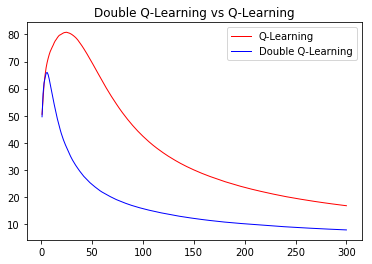

In [22]:
# print graphs
drawGraph(reportQL, reportDQL)

### Conclusion

It is clear that the Double Q-Learning converges faster than Q-learning. We can notice that when the number of actions at B increases, Q-learning needs far more training than Double Q-Learning.